# Classifying near-Antarctic profiles (only make the plots)

This notebook makes the plots from the saved version of the NetCDF dataset

## Initial setup

### Load modules

In [1]:
# modules in this package
import load_and_preprocess as lp
import analysis as at
import bic_and_aic as ba
import plot_tools as pt
import file_io as io
import numpy as np
import xarray as xr
import density
import gmm
# plotting tools
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
import matplotlib as mpl
import cmocean
# os tools
import os.path

# suppress a particular warning
import warnings
warnings.filterwarnings('ignore', 'RuntimeWarning: All-NaN slice encountered')

### Set runtime parameters (file locations, etc.)

In [2]:
# set locations and names
descrip = 'WeddellOnly' # extra description for filename
data_location = '../../so-chic-data/' # input data location
classified_data_location = 'models/profiles_-65to80lon_-85to-30lat_20to1000depth_5K_allDomain_revised.nc'
ploc = 'plots/plots_WeddellClassOnly_top1000m_K04_forPaperRevisions_tmp/'
#ploc = 'tests/'
dloc = 'models/'

# if plot directory doesn't exist, create it
if not os.path.exists(ploc):
    os.makedirs(ploc)
    
# if tSNE directory doesn't exist, create it
if not os.path.exists(ploc+'/tSNE/'):
    os.makedirs(ploc+'/tSNE/')

# single class from previous effort to sub-classify
# don't forget 0 indexing
myClass=1

# calculate BIC and AIC? set max number of components
getBIC = False
max_N = 20

# save the processed output as a NetCDF file?
saveOutput = False

# number of PCA components (roughly 95%)
n_pca = 6

# make decision about n_components_selected (iterative part of analysis)
n_components_selected = 4

#longitude and latitude range
lon_min = -65
lon_max =  80
lat_min = -80
lat_max = -45
# depth range
zmin = 20.0
zmax = 1000.0
# density range
sig0range = (26.6, 28.0)

# temperature and salinity ranges for plotting
lon_range=(lon_min, lon_max)
lat_range=(lat_min, lat_max)
Trange=(-2.2, 6.0)
Srange=(33.5, 35.0)

# create filename for saving GMM and saving labelled profiles
pca_fname = dloc + 'pca_' + str(int(lon_min)) + 'to' + str(int(lon_max)) + 'lon_' + str(int(lat_min)) + 'to' + str(int(lat_max)) + 'lat_' + str(int(zmin)) + 'to' + str(int(zmax)) + 'depth_' + str(int(n_pca)) + descrip
gmm_fname = dloc + 'gmm_' + str(int(lon_min)) + 'to' + str(int(lon_max)) + 'lon_' + str(int(lat_min)) + 'to' + str(int(lat_max)) + 'lat_' + str(int(zmin)) + 'to' + str(int(zmax)) + 'depth_' + str(int(n_components_selected)) + 'K_' + descrip
fname = dloc + 'profiles_' + str(int(lon_min)) + 'to' + str(int(lon_max)) + 'lon_' + str(int(lat_min)) + 'to' + str(int(lat_max)) + 'lat_' + str(int(zmin)) + 'to' + str(int(zmax)) + 'depth_' + str(int(n_components_selected)) + 'K_' + descrip + '.nc'

# colormap
colormap = plt.get_cmap('Dark2', n_components_selected)
colormap_cividis = plt.get_cmap('cividis', 20)

### Load profile data from the Antarctic class (identified in notebook: 1_profile_distribution.ipynb)

load_and_preprocess.load_single_class
----> single-class profiles loaded
plot_tools.plot_profiles


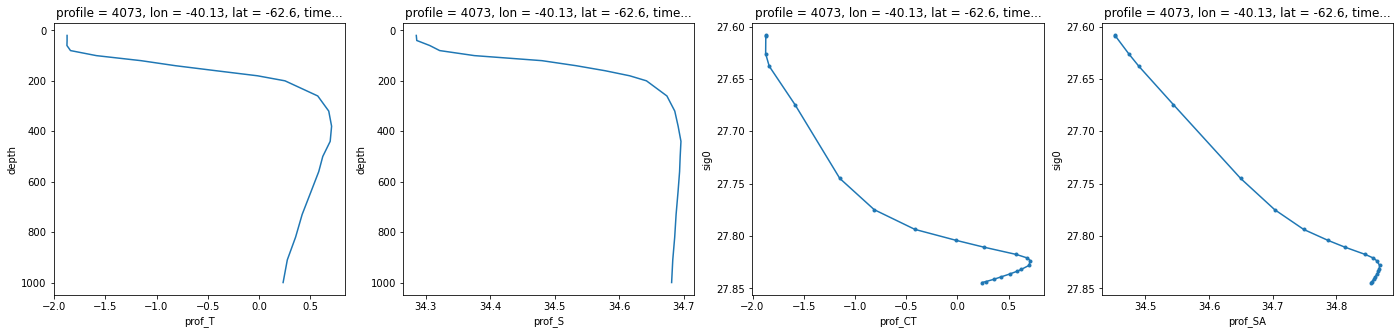

In [3]:
# load single class (just the Weddell One)
profiles = lp.load_single_class(classified_data_location, selected_class=myClass)

# plot random profile
pt.plot_profile(ploc, profiles.isel(profile=1400))

## Dimensionality reduction via PCA

### Carry out principal component expansion

file_io.load_pca
load_and_preprocess.apply_pca
load_and_preprocess.apply_scaling
load_and_preprocess.apply_scaling: using depth levels
0.9455362594627065
plot_tools.plot_pca


/work/weddell_gyre_clusters/src/plot_tools.py:536: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(' ')
/work/weddell_gyre_clusters/src/plot_tools.py:536: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(' ')
/work/weddell_gyre_clusters/src/plot_tools.py:536: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(' ')
/work/weddell_gyre_clusters/src/plot_tools.py:536: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(' ')
/work/weddell_gyre_clusters/src/plot_tools.py:536: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(' ')
/work/weddell_gyre_clusters/src/plot_tools.py:581: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(' ')
/work/weddell_gyre_clusters/src/plot_tools.py:581: UserWarning: FixedFormatter should on

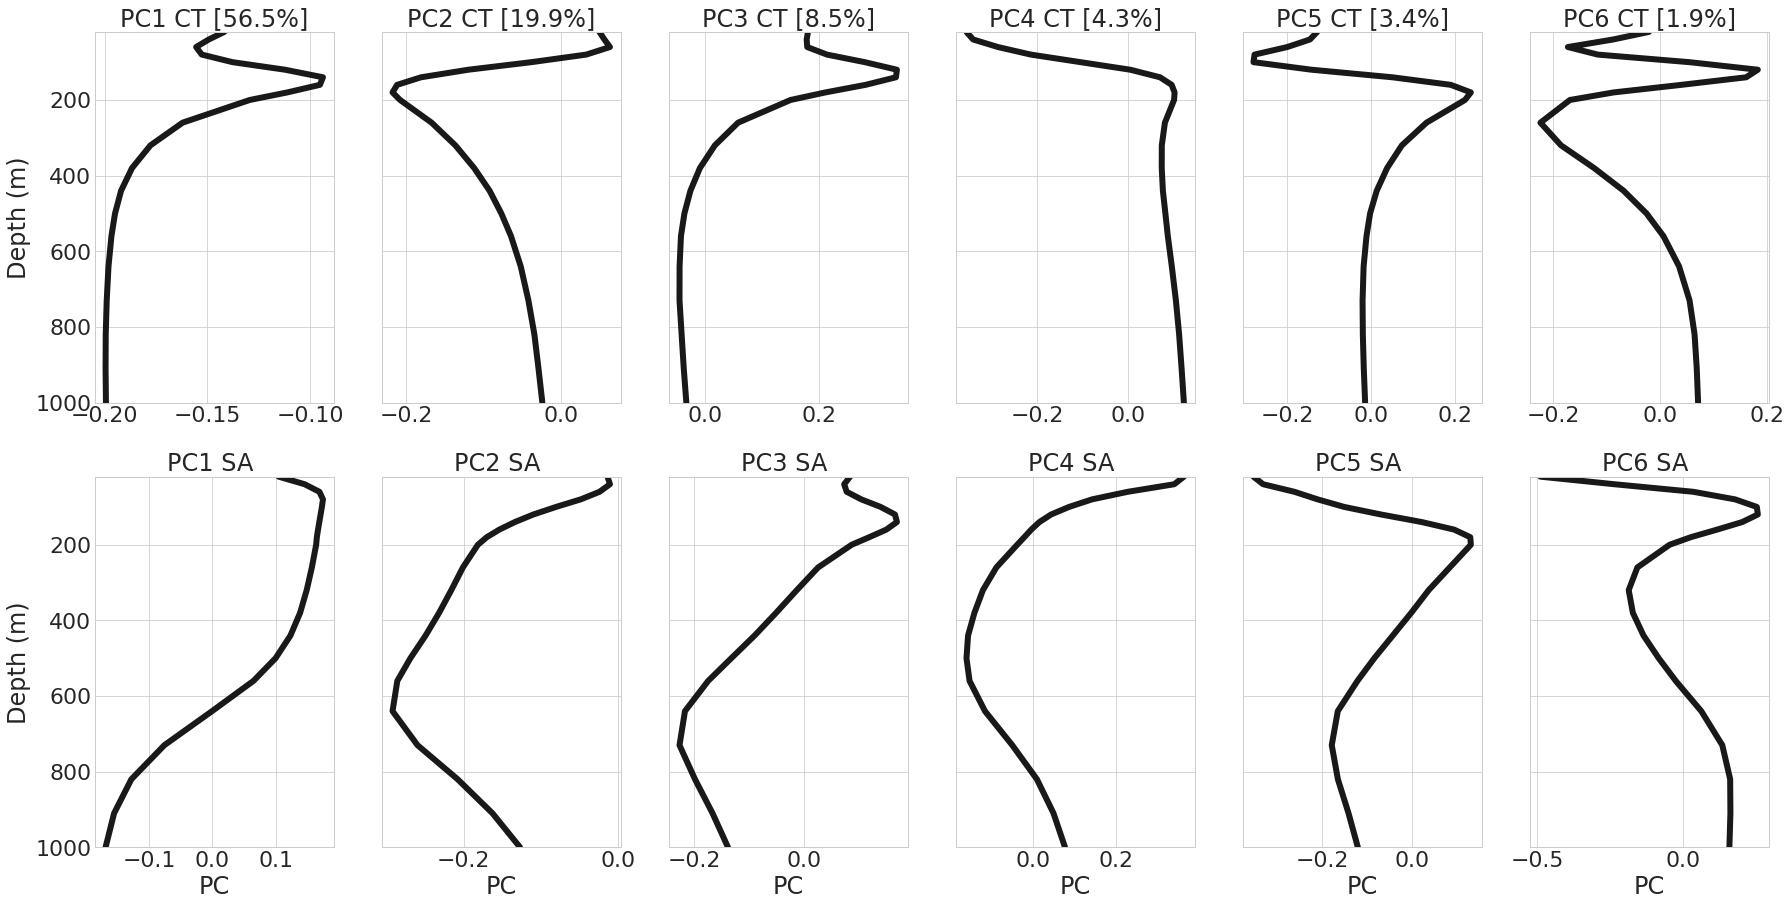

In [4]:
# if trained PCA already exists, load it
#if os.path.isfile(pca_fname):
    
# load existing pca object
pca = io.load_pca(pca_fname)

# apply existing pca object to dataset
Xtrans_full = lp.apply_pca(profiles, pca)
    
# otherwise, go ahead and train it
#else:
#    # generate area-uniform training dataset
#    training_dataset = lp.select_area_uniform_training_dataset(profiles)
#    
#    # fit PCA
#    pca  = lp.fit_pca(training_dataset,
#                      number_of_pca_components=n_pca,
#                      train_frac=0.99)
#    
#    # apply PCA to training dataset alone
#    Xtrans_training = lp.apply_pca(training_dataset, pca)
#    
#    # apply PCA to full dataset
#    Xtrans_full = lp.apply_pca(profiles, pca)
#    
#    # save for future use
#    io.save_pca(pca_fname, pca)

# plot PCA structure
pt.plot_pca_vertical_structure(ploc, profiles, pca, Xtrans_full)

## Classification analysis using GMM

### Profile classificaiton

In [5]:
# loading existing, pre-trained gmm
best_gmm = io.load_gmm(gmm_fname)
    
# apply either loaded GMM
profiles = xr.open_dataset("weddell_classified_n04.nc")

# calculate class statistics
class_means, class_stds = gmm.calc_class_stats(profiles)

file_io.load_gmm
gmm.calc_class_stats


## Analyze class properties

### Examine the Dataset

In [6]:
# simplify Dataset for plotting purposes
dfp = profiles
dfp

<xarray.Dataset>
Dimensions:        (profile: 28397, depth: 21, CLASS: 4, depth_mid: 20)
Coordinates:
  * profile        (profile) int64 13 14 15 16 ... 142282 142301 142320 142330
    lon            (profile) float64 ...
    lat            (profile) float64 ...
  * depth          (depth) float64 20.0 40.0 60.0 80.0 ... 820.0 910.0 1e+03
    time           (profile) datetime64[ns] ...
    year           (profile) int64 ...
    month          (profile) int64 ...
  * CLASS          (CLASS) int64 0 1 2 3
  * depth_mid      (depth_mid) float64 30.0 50.0 70.0 90.0 ... 775.0 865.0 955.0
Data variables: (12/22)
    prof_date      (profile) float64 ...
    prof_YYYYMMDD  (profile) float64 ...
    prof_HHMMSS    (profile) float64 ...
    sig0           (profile, depth) float64 ...
    prof_SA        (profile, depth) float64 ...
    prof_CT        (profile, depth) float64 ...
    ...             ...
    Smin_depth     (profile) float64 ...
    Smax           (profile) float64 ...
    Smax_depth     (profile) float64 ...
    sig0min        (profile) float64 ...
    sig0max        (profile) float64 ...
    imetric        (profile) float64 ...

This is a projection of the full 6D PCA space in which the clustering occurs

plot_tools.plot_pca2D


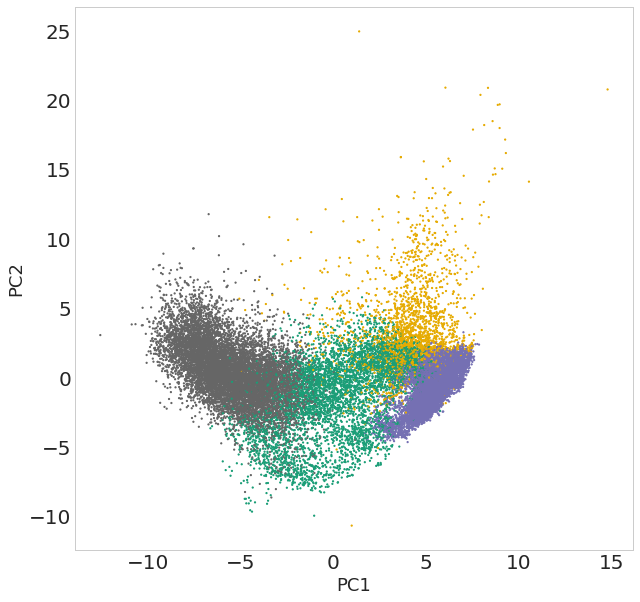

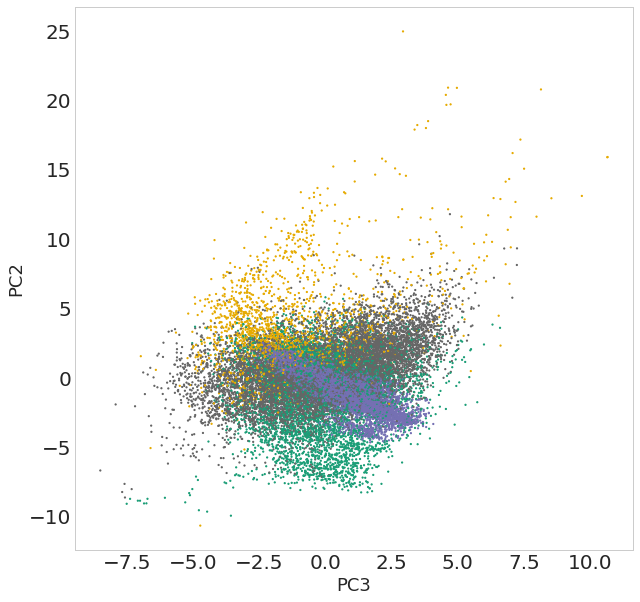

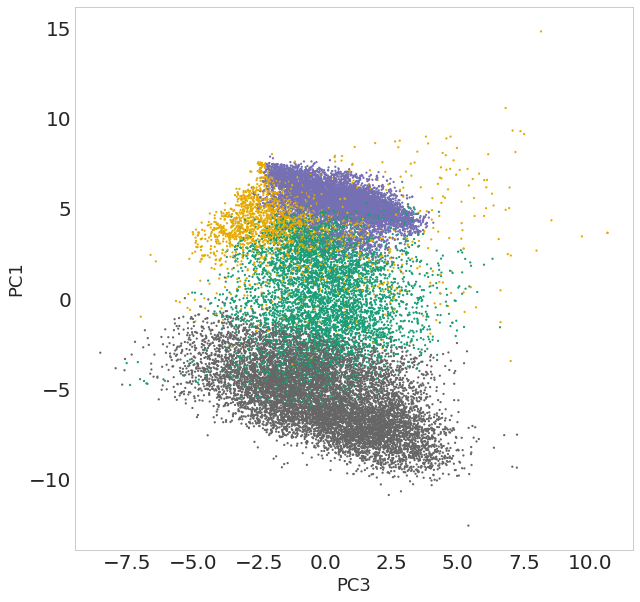

In [7]:
# plot 3D pca structure (now with class labels)
#pt.plot_pca3D(ploc, colormap, dfp, Xtrans_full, frac=0.60, withLabels=True)

# plot 2D view of PCA space
pt.plot_pca2D(ploc, colormap, dfp, Xtrans_full, pca, best_gmm, frac=0.90, withLabels=True, fs=20)

### Plot the vertical structure of the classes (temperature, salinity, and density in the top 1000m)

plot_tools.plot_class_vertical_structures
plot_tools.plot_many_profiles


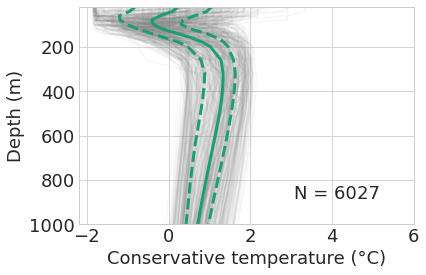

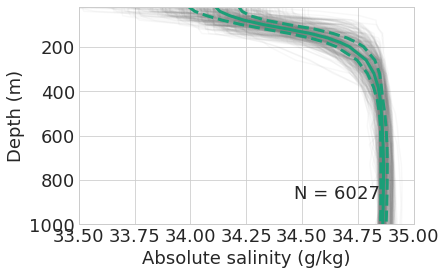

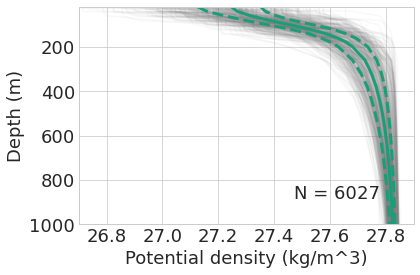

plot_tools.plot_many_profiles


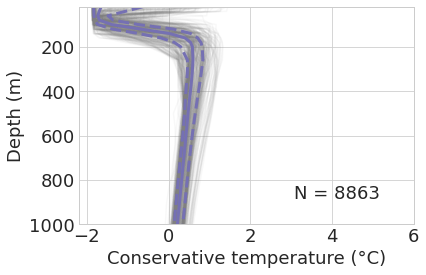

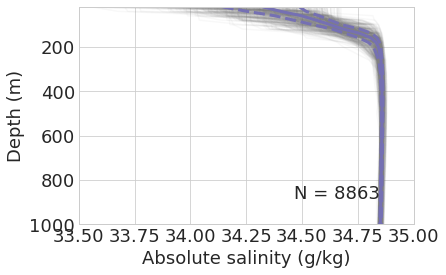

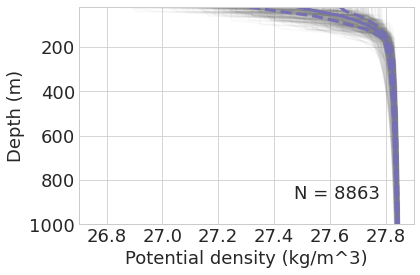

plot_tools.plot_many_profiles


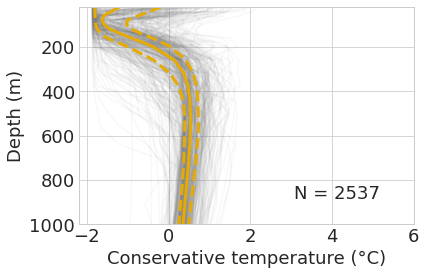

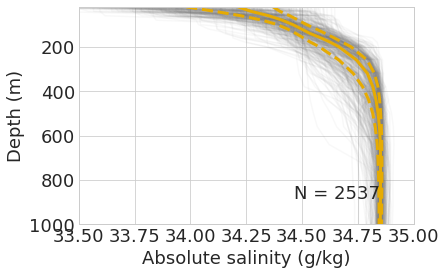

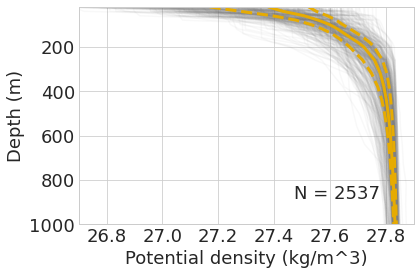

plot_tools.plot_many_profiles


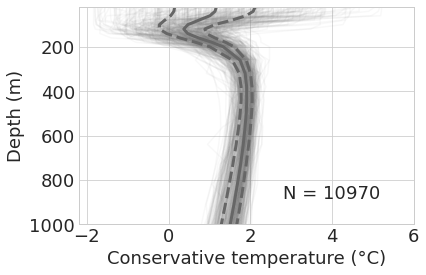

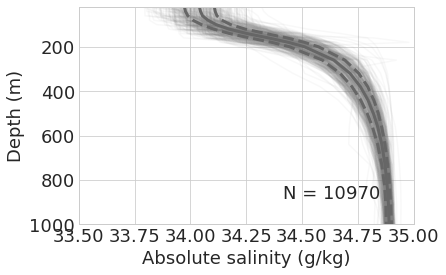

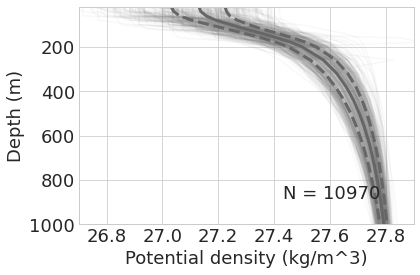

In [12]:
# plot T, S vertical structure of the classes
pt.plot_class_vertical_structures(ploc, dfp, n_components_selected, colormap,
                                  zmin=zmin, zmax=zmax,
                                  Tmin=Trange[0], Tmax=Trange[1],
                                  Smin=Srange[0], Smax=Srange[1],
                                  sig0min = 26.7, sig0max = 27.9,
                                  frac=0.25, alpha=0.05, withDensity=True)

### Plot the vertical structure of the classes (temperature, salinity, and density in the top 400m)

plot_tools.plot_class_vertical_structures
plot_tools.plot_many_profiles


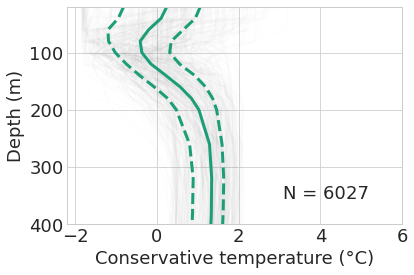

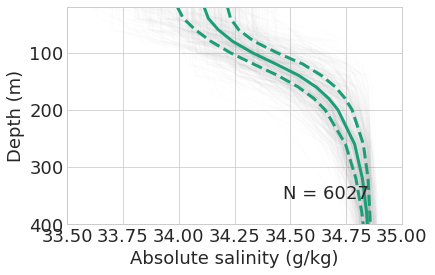

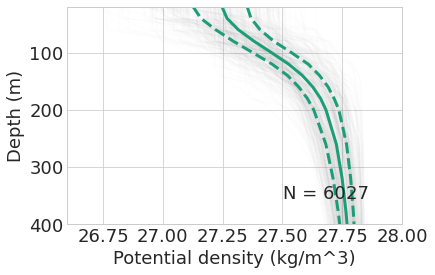

plot_tools.plot_many_profiles


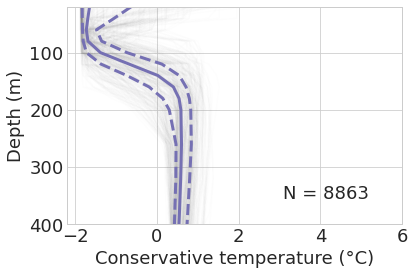

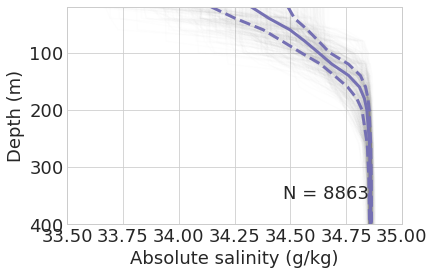

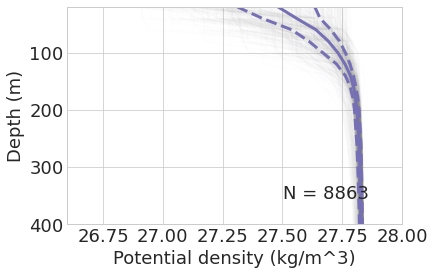

plot_tools.plot_many_profiles


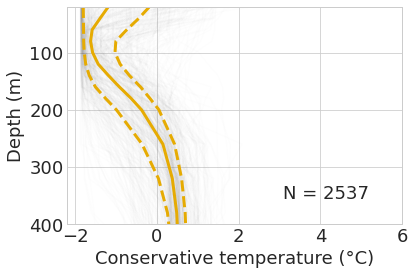

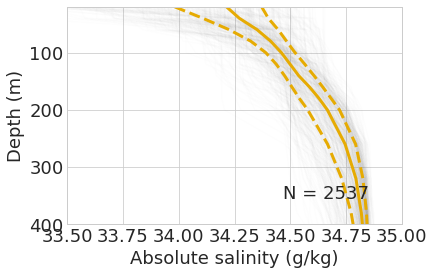

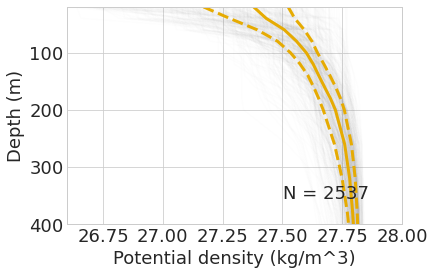

plot_tools.plot_many_profiles


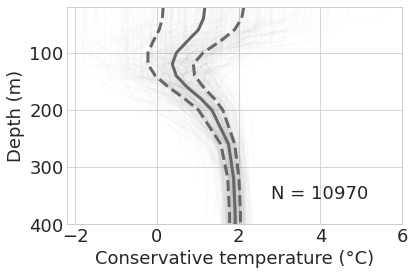

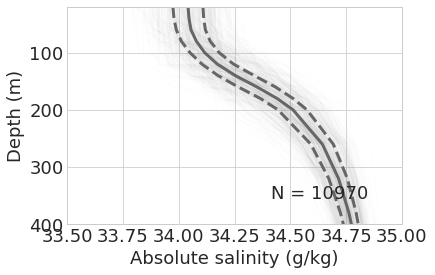

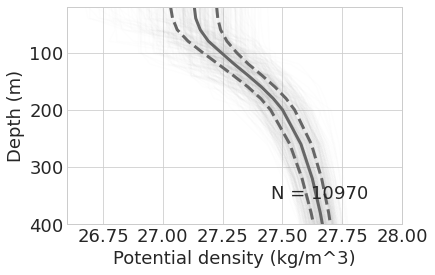

In [9]:
pt.plot_class_vertical_structures(ploc, profiles, n_components_selected, colormap,
                                  zmin=zmin, zmax=400,
                                  Tmin=Trange[0], Tmax=Trange[1],
                                  Smin=Srange[0], Smax=Srange[1],
                                  sig0min=sig0range[0], sig0max=sig0range[1],
                                  frac=0.25, description='top400m', withDensity=True)